<a href="https://colab.research.google.com/github/makaumun/AirBnB_clone/blob/main/GA5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 26 not upgraded.
Need to get 420 MB of archives.
After this operation, 1,622 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 8s (54.1 MB/s)
(Reading database ... 129501 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
(Reading database ... 129478 files and directories currently installed.)
Prepari

In [29]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model

target_shape = (200, 200)

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
data_path = '/content/drive/MyDrive/Data'

anchor_images_path = '/content/drive/MyDrive/Data/left'
positive_images_path = '/content/drive/MyDrive/Data/right'

anchor_images_path = Path(anchor_images_path)
positive_images_path = Path(positive_images_path)

In [6]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [7]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

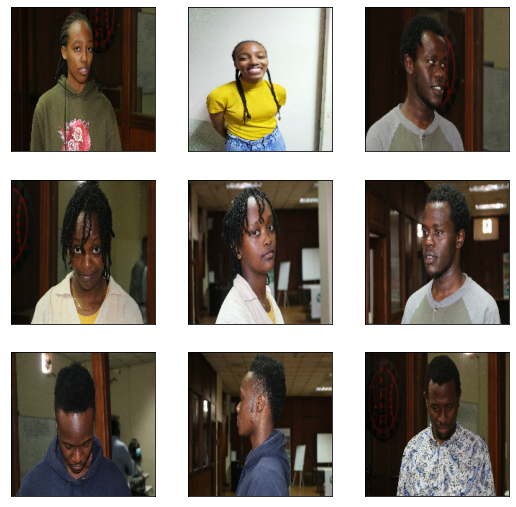

In [8]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [21]:
#Load the InceptionV3 model
pre_trained_model = InceptionV3(
    weights="imagenet", 
    input_shape=target_shape + (3,), 
    include_top=False
)

for layer in pre_trained_model.layers:
  layer.trainable = False


pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 99, 99, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_384 (Batch  (None, 99, 99, 32)  96          ['conv2d_376[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [22]:
last_layer = pre_trained_model.get_layer('mixed7')

last_output = last_layer.output

In [24]:
#Add customer layers to the pre-trained model
flatten = layers.Flatten()(last_output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(pre_trained_model.input, output, name="Embedding")

In [26]:
#model summary
embedding.summary()

Model: "Embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 99, 99, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_384 (Batch  (None, 99, 99, 32)  96          ['conv2d_376[0][0]']             
 Normalization)                                                                                   
                                                                                          

In [30]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(inception_v3.preprocess_input(anchor_input)),
    embedding(inception_v3.preprocess_input(positive_input)),
    embedding(inception_v3.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [31]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [52]:
#Train and fit the model
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer = RMSprop(learning_rate=0.0001), metrics=['accuracy'])
history = siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 0.0227

1/1 [==============================] - 37s 37s/step - loss: 0.0227 - val_loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 28s 28s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.0227

1/1 [==============================] - 29s 29s/step - loss: 0.0227 - val_loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 0.2117

1/1 [==============================] - 28s 28s/step - loss: 0.2117 - val_loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - ETA: 0s - loss: 0.6533

1/1 [==============================] - 28s 28s/step - loss: 0.6533 - val_loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - ETA: 0s - loss: 0.1494

1/1 [==============================] - 31s 31s/step - loss: 0.1494 - val_loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - ETA: 0s - loss: 0.1123

1/1 [==============================] - 28s 28s/step - loss: 0.1123 - val_loss: 0.1000
Epoch 8/10
1/1 [==============================] - ETA: 0s - loss: 0.0446

1/1 [==============================] - 28s 28s/step - loss: 0.0446 - val_loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - ETA: 0s - loss: 0.0032

1/1 [==============================] - 28s 28s/step - loss: 0.0032 - val_loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - ETA: 0s - loss: 0.0227

1/1 [==============================] - 28s 28s/step - loss: 0.0227 - val_loss: 0.0000e+00


In [51]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


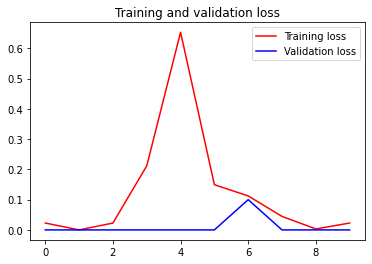

<Figure size 432x288 with 0 Axes>

In [55]:
#Plot the loss and validation loss
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()